In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import tensorboard as tb

In [3]:
#experiment_id = "fL8jM1JXTbC5SnpQ90JWlQ"
#experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
#df = experiment.get_scalars()
#df.to_csv("results_logs.tsv", sep="\t", index=False)
#df

In [28]:
df = pd.read_csv("results_logs.tsv", sep="\t")
df.rename(columns={"run": "Method", "tag": "Feature", "value": "value"}, inplace=True)
df["Metric"] = df.Feature.str.split("_").str[0].str.upper()
df.Method.replace({"version_5": "PlantBert"}, inplace=True)
#df = df[df.Method.isin(["DeepSEA", "DNABERT", "PlantBert"])]
df = df[df.Method.isin(["DeepSEA", "DNABERT",])]
df = df[df.Metric.isin(["AUPRC", "AUROC"])]
df["Feature class"] = df.Feature.str.split("_").str[1]
df

,Method,Feature,step,value,Metric,Feature class
0,DNABERT,auprc_DHS_Ath_flower_14_days,27080,0.634451,AUPRC,DHS
1,DNABERT,auprc_DHS_Ath_inflorescence_normal,27080,0.440137,AUPRC,DHS
2,DNABERT,auprc_DHS_Ath_leaf_normal,27080,0.465153,AUPRC,DHS
3,DNABERT,auprc_DHS_Ath_open_flower_normal,27080,0.505751,AUPRC,DHS
4,DNABERT,auprc_DHS_Ath_root_7_days,27080,0.574621,AUPRC,DHS
...,...,...,...,...,...,...
1603,DeepSEA,auroc_TFBS_AT5G63790_Ath_seedling_normal,86632,0.880922,AUROC,TFBS
1604,DeepSEA,auroc_TFBS_AT5G65310_Ath_seedling_ABA_treatmen...,86632,0.927400,AUROC,TFBS
1605,DeepSEA,auroc_TFBS_AT5G65310_Ath_seedling_normal,86632,0.922578,AUROC,TFBS
1606,DeepSEA,auroc_TFBS_AT5G67300_Ath_seedling_ABA_treatmen...,86632,0.923805,AUROC,TFBS


In [29]:
wandb_results = pd.read_csv("wandb_export_2022-06-14T13_43_54.321-07_00.csv")
wandb_results = wandb_results[wandb_results.Name=="ConvNet_512_ft"]
wandb_results = wandb_results.T.squeeze()
wandb_results

Name                        ConvNet_512_ft
State                             finished
Notes                                    -
User                        gonzalobenegas
Tags                                   NaN
                                 ...      
val/median_auroc_dnase            0.953587
val/median_auroc_histone          0.887438
val/median_auroc_tf               0.919206
val/neg_median_auprc             -0.649011
val/neg_median_auroc             -0.928211
Name: 0, Length: 264, dtype: object

In [30]:
features = df.Feature.unique()
values = [wandb_results[f"test/{feature}"] for feature in features]
df_wandb = pd.DataFrame(dict(Feature=features, value=values))
df_wandb["Method"] = "ConvNet"
df_wandb["Metric"] = df_wandb.Feature.str.split("_").str[0].str.upper()
df_wandb["Feature class"] = df_wandb.Feature.str.split("_").str[1]
df_wandb

,Feature,value,Method,Metric,Feature class
0,auprc_DHS_Ath_flower_14_days,0.670105,ConvNet,AUPRC,DHS
1,auprc_DHS_Ath_inflorescence_normal,0.488406,ConvNet,AUPRC,DHS
2,auprc_DHS_Ath_leaf_normal,0.480446,ConvNet,AUPRC,DHS
3,auprc_DHS_Ath_open_flower_normal,0.555538,ConvNet,AUPRC,DHS
4,auprc_DHS_Ath_root_7_days,0.605631,ConvNet,AUPRC,DHS
...,...,...,...,...,...
213,auroc_TFBS_AT5G63790_Ath_seedling_normal,0.886939,ConvNet,AUROC,TFBS
214,auroc_TFBS_AT5G65310_Ath_seedling_ABA_treatmen...,0.939568,ConvNet,AUROC,TFBS
215,auroc_TFBS_AT5G65310_Ath_seedling_normal,0.935373,ConvNet,AUROC,TFBS
216,auroc_TFBS_AT5G67300_Ath_seedling_ABA_treatmen...,0.936769,ConvNet,AUROC,TFBS


In [31]:
df = pd.concat([df, df_wandb], ignore_index=True)

In [32]:
method_order = ["DeepSEA", "DNABERT", "ConvNet"]

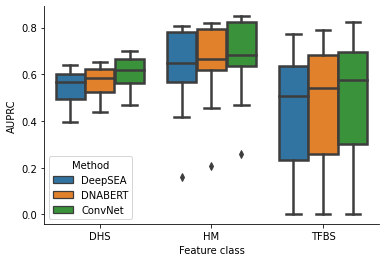

In [34]:
sns.boxplot(x="Feature class", y="value", hue="Method", data=df[df.Metric=="AUPRC"], hue_order=method_order, linewidth=2.5);
sns.despine()
plt.ylabel("AUPRC")
plt.savefig("auprc_boxplot.svg", bbox_inches='tight')

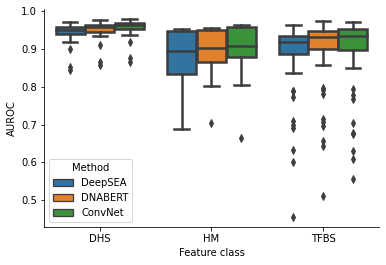

In [35]:
sns.boxplot(x="Feature class", y="value", hue="Method", data=df[df.Metric=="AUROC"], hue_order=method_order, linewidth=2.5);
sns.despine()
plt.ylabel("AUROC")
plt.savefig("auroc_boxplot.svg", bbox_inches='tight')

In [37]:
def scatter_plot(df, metric, methods):
    df2 = df[df.Metric==metric].pivot(index='Feature', columns='Method', values='value')
    df2["Feature class"] = df2.index.str.split("_").str[1]
    sns.scatterplot(data=df2, x=methods[0], y=methods[1], hue="Feature class", palette="Set2", linewidth=0)
    vmin, vmax = df2[methods].min().min() - 1/100, df2[methods].max().max() + 1/100
    plt.xlim([vmin, vmax])
    plt.ylim([vmin, vmax])
    sns.despine()
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.title(metric)
    plt.gca().set_aspect('equal', 'box')
    plt.savefig(f"scatterplot_{metric}_{methods}.svg", bbox_inches='tight')

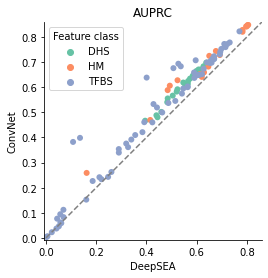

In [38]:
scatter_plot(df, "AUPRC", ["DeepSEA", "ConvNet"])

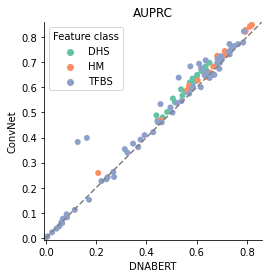

In [39]:
scatter_plot(df, "AUPRC", ["DNABERT", "ConvNet"])

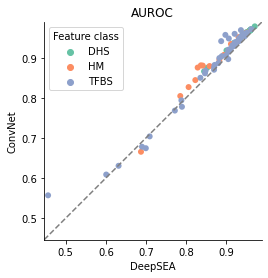

In [40]:
scatter_plot(df, "AUROC", ["DeepSEA", "ConvNet"])

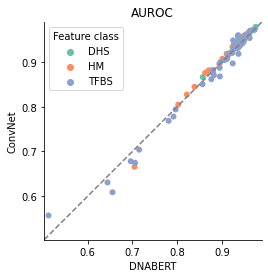

In [41]:
scatter_plot(df, "AUROC", ["DNABERT", "ConvNet"])